<a href="https://colab.research.google.com/github/Spisor/PancreasArtificial/blob/master/Pancreas_Artificial_AISaturdays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.-PREPARACION DE LOS DATOS

##0.1.- Parseo de los archivos .json de origen

In [0]:
import pandas as pd


def saveCSV():
	entries.to_csv('entries.csv')
	deviceStatus.to_csv('devicestatus.csv')
	treatments.to_csv('treatments.csv')

entries = pd.read_json('entries.json', lines=True)
deviceStatus = pd.read_json('devicestatus.json', lines=True)
treatments = pd.read_json('treatments.json', lines=True)

deviceStatus = pd.concat([deviceStatus.drop(['pump'], axis=1), deviceStatus['pump'].apply(pd.Series)], axis=1)
deviceStatus = pd.concat([deviceStatus.drop(['iob'], axis=1), deviceStatus['iob'].apply(pd.Series)], axis=1)
deviceStatus = pd.concat([deviceStatus.drop(['status'], axis=1), deviceStatus['status'].apply(pd.Series)], axis=1)
deviceStatus = deviceStatus.drop([0], axis=1)

saveCSV()

Una vez generadoslos .csv, utilizamos la herramiena KNIME para todas las operaciones de ETL hasta obtener el DataSet. La aplicación de escritorio es completamente gratuita y 100% funcional.

[https://www.knime.com/]

A continuación se muestra el workflow programado hasta obtener el DataSet final. Una copia del workflow esta disponible en el GitHub del proyecto.






![texto alternativo](https://)
IMAGEN

#1.- PREPARACIÓN DEL ENTORNO DE TRABAJO

##1.1.- Instalar Librerías fastai

In [0]:
!pip install fastai==0.7.0 > /dev/null

ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.


In [0]:
!pip install treeinterpreter==0.2.2 > /dev/null

##1.2.- Importar modulos y librerías necesarios

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import pandas as pd
import numpy as np
import datetime

##1.3.- Código para cargar archivo dataset desde disco local

Una vez ejecutada la celda es necesario seleccionar Elegir archivo y seleccionarlo desde la ubicación local

In [0]:
from google.colab import files 
uploaded = files.upload()

Saving pancreas_nuevo_dataset_3_con_historic.csv to pancreas_nuevo_dataset_3_con_historic.csv


El siguiente código  ejecuta órdenes del entorno IPython. Lo que se solicita con dichas ordenes es que el entorno recargue los módulos necesarios cada vez que se ejecute código



In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Comprobamos que el fichero se ha almacenado correctamente

In [0]:
!ls -l


total 608
-rw-r--r-- 1 root root 616573 Jul 10 08:33 pancreas_nuevo_dataset_3_con_historic.csv
drwxr-xr-x 1 root root   4096 Jul  3 16:14 sample_data


Finalmente, cargamos el fichero en un objeto DataFrame de Pandas.

In [0]:
df = pd.read_csv('pancreas_nuevo_dataset_3_con_historic.csv')

In [0]:
df.head()

,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1
0,25.0,0.114437,142,Flat,2019,5,20,3,6,9,75.0,50.0,75.0,50.0,75.0,151,150,149,147,145
1,75.0,0.112676,137,Flat,2019,5,20,3,6,19,50.0,75.0,50.0,75.0,25.0,150,149,147,145,142
2,50.0,0.110915,144,Flat,2019,5,20,3,6,34,75.0,50.0,75.0,25.0,75.0,149,147,145,142,137
3,50.0,0.109155,140,Flat,2019,5,20,3,6,39,50.0,75.0,25.0,75.0,50.0,147,145,142,137,144
4,75.0,0.107394,139,Flat,2019,5,20,3,6,44,75.0,25.0,75.0,50.0,50.0,145,142,137,144,140


A continuación se hace una breve descripción de las variables que componen el DataSet:

**- insulin:** Es la variable objetivo y representa la cantidad de insulina basal que la bomba insufla cada 5 minutos(1).

**- bolusiob:** Se trata de una estimación dada por el sistema del total de la insulina 'activa' existente en el organismo del paciente.

**- sgv:** Es el valor de nivel de glucosa detectado por el sensor de medición.

**- Tendencia (1):** Es un indicador generado en base a la especificación del fabricante de la bomba y da una estimación de lo"rapido" o "lento" que varía el nivel de glucosa.

    *Flat:* indica
    *+++, ---:*
    *++, --:*
    *+,-:*
    
**- Year, Month, Week, Day of week, Hour, Minute:** Fecha-Hora correspondiente a los eventos que aportan la información reflejada.

**- insulin-1 - insulin -5:** Valores de insulina insuflados en los 5 anteriores eventos temporales.

**- sgv-1- insulin - 5:** Valores de glucosa medidos en los 5 anteriores eventos temporales.



*(1) Pueden aparecer eventos intermedios correspondientes a mensajes procedentes de la misma bomba o dispositivos complementarios, como el medidor de insulina en sangre.*

In [0]:
df.columns

Index(['insulin', 'bolusiob', 'sgv', 'Tendencia (#1)', 'Year',
       'Month (number)', 'Week', 'Day of week (number)', 'Hour', 'Minute',
       'insulin-5', 'insulin-4', 'insulin-3', 'insulin-2', 'insulin-1',
       'sgv-5', 'sgv-4', 'sgv-3', 'sgv-2', 'sgv-1'],
      dtype='object')

Estas variables son las correspondientesa los datos aportados por la bomba de insulina, referentes a los elementos que componen el sistema.

Además, se han generado nuevas variables:



#1.3.1 Nuevas variables

Las nuevas variables han sido extraidas de un trabajo similar, que se puede consular en:
https://nbviewer.jupyter.org/gist/mariusae/18a62db9cc32d09dc691fd4f78dcdbfa

Las variables son:

**- deltasgv:** El cambio de la glucosa cada 5 minutos.

**- mendeltagv:** Es la media desplazada de los cambios de los valores de la glucosa.

**- prevmeandeltasgv:** Valor medio del nivel de azucar en el instante anterior



In [0]:
maxdelta = 15
df['deltasgv'] = df['sgv'] - df['sgv'].shift(1)
df['deltasgv'] = np.maximum(np.minimum(df['deltasgv'], maxdelta), -maxdelta)

df['meandeltasgv'] = df['deltasgv'].rolling(window=4, min_periods=1).mean()
df['prevmeandeltasgv'] = df['meandeltasgv'].shift(1)
df[np.isfinite(df['sgv'])].tail(5)

,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1,deltasgv,meandeltasgv,prevmeandeltasgv
6741,50.0,0.0,120,Flat,2019,6,26,2,20,7,75.0,75.0,75.0,75.0,75.0,112,114,115,117,120,0.0,1.50,2.00
6742,25.0,0.0,120,Flat,2019,6,26,2,20,12,75.0,75.0,75.0,75.0,50.0,114,115,117,120,120,0.0,1.25,1.50
6743,25.0,0.0,118,Flat,2019,6,26,2,20,17,75.0,75.0,75.0,50.0,25.0,115,117,120,120,120,-2.0,0.25,1.25
6744,25.0,0.0,115,Flat,2019,6,26,2,20,28,75.0,75.0,50.0,25.0,25.0,117,120,120,120,118,-3.0,-1.25,0.25
6745,25.0,0.0,114,Flat,2019,6,26,2,20,32,75.0,50.0,25.0,25.0,25.0,120,120,120,118,115,-1.0,-1.50,-1.25


In [0]:
df.head()

,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1,deltasgv,meandeltasgv,prevmeandeltasgv
0,25.0,0.114437,142,Flat,2019,5,20,3,6,9,75.0,50.0,75.0,50.0,75.0,151,150,149,147,145,NaN,NaN,NaN
1,75.0,0.112676,137,Flat,2019,5,20,3,6,19,50.0,75.0,50.0,75.0,25.0,150,149,147,145,142,-5.0,-5.000000,NaN
2,50.0,0.110915,144,Flat,2019,5,20,3,6,34,75.0,50.0,75.0,25.0,75.0,149,147,145,142,137,7.0,1.000000,-5.000000
3,50.0,0.109155,140,Flat,2019,5,20,3,6,39,50.0,75.0,25.0,75.0,50.0,147,145,142,137,144,-4.0,-0.666667,1.000000
4,75.0,0.107394,139,Flat,2019,5,20,3,6,44,75.0,25.0,75.0,50.0,50.0,145,142,137,144,140,-1.0,-0.750000,-0.666667


In [0]:
df = df.fillna(df.mean()) # Rellenamos los NaN con la media

Por ultimo añadimos un parámetro relacionado con la insulina actuva en cada instante. Esta variable, además, añade la naturaleza farmacológica de la insulina utilizada.

**-ai:** Insulina activa


In [0]:
df['ubi']=0 # No hay aportaciones de insulina lenta

In [0]:
def expia(t, tp, td):
    """Exponential insulin curve, parameterized by peak and duration, 
    due to Dragan Maksimovic (@dm61).
    Worked by Pete (@ps2) in the notebook
    	https://github.com/ps2/LoopIOB/blob/master/ScalableExp.ipynb
    Reworked here to be vectorized by numpy.
    """
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*(tau/td)
    S = 1/(1-a+(1+a)*np.exp(-td/tau))
    return np.maximum(0., (S/np.power(tau,2))*t*(1-t/td)*np.exp(-t/tau))

# W is the window of history that we consider. 
# Our periods are 5 minutes, so 12*6 = 6 hours.
W = 12*6
Wtime = np.linspace(0., 1.*W, W, endpoint=False, dtype='float32')
humalog_coeffs = expia(Wtime, 13., 48.)  # 1:05h peak, 4h duration
fiasp_coeffs = expia(Wtime, 7., 45.)  # 35m peak, 3:45h duration

# We flip them because we're going to be applying these to "trailing" data.
humalog_coeffs = np.flip(humalog_coeffs, 0)
fiasp_coeffs = np.flip(fiasp_coeffs, 0)

# Ia indicates insulin activity. This is computed by adding up the 
# contributions of each delivery over a rolling window. Conveniently,
# this is equivalent to taking the dot product of the deliveries in the
# window with the coefficients computed above.
df['ia'] = df['insulin'].rolling(window=W).apply(lambda pids: np.dot(pids, humalog_coeffs)) + \
    df['ubi'].rolling(window=W).apply(lambda pids: np.dot(pids, fiasp_coeffs))
df[np.isfinite(df['sgv'])].tail(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1,deltasgv,meandeltasgv,prevmeandeltasgv,ubi,ia
6741,50.0,0.0,120,Flat,2019,6,26,2,20,7,75.0,75.0,75.0,75.0,75.0,112,114,115,117,120,0.0,1.50,2.00,0,48.439181
6742,25.0,0.0,120,Flat,2019,6,26,2,20,12,75.0,75.0,75.0,75.0,50.0,114,115,117,120,120,0.0,1.25,1.50,0,48.970269
6743,25.0,0.0,118,Flat,2019,6,26,2,20,17,75.0,75.0,75.0,50.0,25.0,115,117,120,120,120,-2.0,0.25,1.25,0,49.256509
6744,25.0,0.0,115,Flat,2019,6,26,2,20,28,75.0,75.0,50.0,25.0,25.0,117,120,120,120,118,-3.0,-1.25,0.25,0,49.343943
6745,25.0,0.0,114,Flat,2019,6,26,2,20,32,75.0,50.0,25.0,25.0,25.0,120,120,120,118,115,-1.0,-1.50,-1.25,0,49.257783


Este parámetro tambien genera valores NaN, eliminandose de la misma forma

In [0]:
df = df.fillna(df.mean()) # Rellenamos los NaN con la media

##1.4.- Tratamiento de variables categóricas.##

In [0]:
df['Tendencia (#1)'].unique()

array(['Flat', '++', '-', '+', '---', '--', '+++'], dtype=object)

In [0]:
df['Tendencia (#1)'] = df['Tendencia (#1)'].astype('category').values

In [0]:
df['Tendencia (#1)'].cat.set_categories(['+', '++', '+++', '-', '--', '---', 'Flat'], ordered=True, inplace=True)
df['Tendencia (#1)'] = df['Tendencia (#1)'].cat.codes

In [0]:
df['Tendencia (#1)'].head()

0    6
1    6
2    6
3    6
4    6
Name: Tendencia (#1), dtype: int8

##1.5 Primer contacto con la naturaleza de los datos. Estadísticos generales##

In [0]:
df.describe()

,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1,deltasgv,meandeltasgv,prevmeandeltasgv,ubi,ia
count,6746.000000,6746.000000,6746.000000,6746.000000,6746.0,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.000000,6746.0,6746.000000
mean,68.703676,0.755228,149.678624,4.996739,2019.0,5.588349,22.752742,3.933887,10.517344,29.314260,68.729618,68.725912,68.722206,68.714794,68.711088,149.701601,149.697006,149.692559,149.687963,149.683220,0.477391,0.477292,0.477585,0.0,68.882861
std,34.349161,1.108875,36.537746,2.092803,0.0,0.492169,1.751144,2.007418,7.163416,17.300132,34.333672,34.334344,34.337715,34.341755,34.345124,36.527168,36.528955,36.530744,36.532781,36.535207,5.202052,3.553006,3.552924,0.0,17.425730
min,0.000000,0.000000,5.000000,0.000000,2019.0,5.000000,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,-15.000000,-12.750000,-12.750000,0.0,0.000000
25%,50.000000,0.000000,122.000000,6.000000,2019.0,5.000000,21.000000,2.000000,4.000000,14.000000,50.000000,50.000000,50.000000,50.000000,50.000000,122.000000,122.000000,122.000000,122.000000,122.000000,-2.000000,-1.750000,-1.750000,0.0,57.174580
50%,75.000000,0.273580,147.000000,6.000000,2019.0,6.000000,23.000000,4.000000,10.000000,29.000000,75.000000,75.000000,75.000000,75.000000,75.000000,147.000000,147.000000,147.000000,147.000000,147.000000,0.000000,0.250000,0.250000,0.0,67.885310
75%,100.000000,1.031758,173.000000,6.000000,2019.0,6.000000,24.000000,6.000000,17.000000,44.000000,100.000000,100.000000,100.000000,100.000000,100.000000,173.000000,173.000000,173.000000,173.000000,173.000000,3.000000,2.500000,2.500000,0.0,80.770320
max,175.000000,8.837500,335.000000,6.000000,2019.0,6.000000,26.000000,7.000000,23.000000,59.000000,175.000000,175.000000,175.000000,175.000000,175.000000,335.000000,335.000000,335.000000,335.000000,335.000000,15.000000,13.500000,13.500000,0.0,124.463906


In [0]:
df.sgv.var()

1335.006858062888

##1.6.- Información sobre las variables. Tipos## 

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6746 entries, 0 to 6745
Data columns (total 25 columns):
insulin                 6746 non-null float64
bolusiob                6746 non-null float64
sgv                     6746 non-null int64
Tendencia (#1)          6746 non-null int8
Year                    6746 non-null int64
Month (number)          6746 non-null int64
Week                    6746 non-null int64
Day of week (number)    6746 non-null int64
Hour                    6746 non-null int64
Minute                  6746 non-null int64
insulin-5               6746 non-null float64
insulin-4               6746 non-null float64
insulin-3               6746 non-null float64
insulin-2               6746 non-null float64
insulin-1               6746 non-null float64
sgv-5                   6746 non-null int64
sgv-4                   6746 non-null int64
sgv-3                   6746 non-null int64
sgv-2                   6746 non-null int64
sgv-1                   6746 non-null int64


# Normalizacion

In [0]:
df.head()

,insulin,bolusiob,sgv,Tendencia (#1),Year,Month (number),Week,Day of week (number),Hour,Minute,insulin-5,insulin-4,insulin-3,insulin-2,insulin-1,sgv-5,sgv-4,sgv-3,sgv-2,sgv-1,deltasgv,meandeltasgv,prevmeandeltasgv,ubi,ia
0,25.0,0.114437,142,6,2019,5,20,3,6,9,75.0,50.0,75.0,50.0,75.0,151,150,149,147,145,0.477391,0.477292,0.477585,0,68.882861
1,75.0,0.112676,137,6,2019,5,20,3,6,19,50.0,75.0,50.0,75.0,25.0,150,149,147,145,142,-5.000000,-5.000000,0.477585,0,68.882861
2,50.0,0.110915,144,6,2019,5,20,3,6,34,75.0,50.0,75.0,25.0,75.0,149,147,145,142,137,7.000000,1.000000,-5.000000,0,68.882861
3,50.0,0.109155,140,6,2019,5,20,3,6,39,50.0,75.0,25.0,75.0,50.0,147,145,142,137,144,-4.000000,-0.666667,1.000000,0,68.882861
4,75.0,0.107394,139,6,2019,5,20,3,6,44,75.0,25.0,75.0,50.0,50.0,145,142,137,144,140,-1.000000,-0.750000,-0.666667,0,68.882861


#2.- GENERACION DEL MODELO: RANDOM FOREST#

##2.1.- Preparación de los datos#

Separamos la variable objetivo *(insulin)* de las variables predictoras.

In [0]:
Y = df.insulin
X = df.drop('insulin', axis=1)

Generamos los conjuntos de datos de entrenamiento *(trn)* y validación *(valid)*.

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 1200  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(Y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((5546, 24), (5546,), (1200, 24), (1200,))

##2.2.- Métrica#

En este caso se a elegido *RMSE (Raiz del Error Cuadrático Medio)*.
El codigo a continuación define la función para el cálculo del estimador así como la función para el calculo de scores del modelo.

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(model):
    res = [rmse(model.predict(X_train), y_train), rmse(model.predict(X_valid), y_valid),
                model.score(X_train, y_train), model.score(X_valid, y_valid)]
    print('Error Muestras Entrenamiento:',res[0])
    print('Error Muestras Test:',res[1])
    print('R2 Muestras Entrenamiento:',res[2])
    print('R2 Muestras Test:',res[3])
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    print(res)

##2.3.- Primer modelo y primer arbol#

In [0]:
model = RandomForestRegressor(n_estimators=1, n_jobs=-1, max_depth=3, bootstrap=False)
model.fit(X_train, y_train)
print_score(model)

Error Muestras Entrenamiento: 24.79178689801134
Error Muestras Test: 23.698457951620174
R2 Muestras Entrenamiento: 0.5073522199892525
R2 Muestras Test: 0.35090777075898183
[24.79178689801134, 23.698457951620174, 0.5073522199892525, 0.35090777075898183]


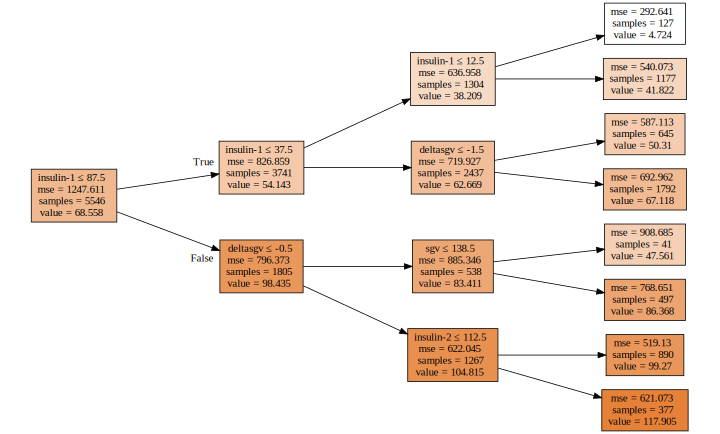

In [0]:
draw_tree(model.estimators_[0], X_train, precision=3)

Este es un ejemplo del arbol de decisión obtenido, a continuación se muestra el error de cada uno de los árboles generados con el conjunto de entrenamiento, que da como resultado el valor mostrado anteriormente.

##2.4.- Bagging

Vamos a utilizar la técnica del anidamiento de árboles ( Bagging), para mejorarlos indicadores del modelo.

In [0]:
model = RandomForestRegressor (n_jobs = -1, n_estimators=40)  # Si se omite n_esimators, se toma 10
model.fit (X_train, y_train) 
print_score (model)

Error Muestras Entrenamiento: 7.767738249027789
Error Muestras Test: 20.803309094248284
R2 Muestras Entrenamiento: 0.9516373560955808
R2 Muestras Test: 0.49981452219714073
[7.767738249027789, 20.803309094248284, 0.9516373560955808, 0.49981452219714073]


Con el fin de  tener una idea del número de estimadores, podemos representar como varía parametro R2 a medida que se añaden estimadores. Vemos como a partir de 10, R2 se estabiliza.

In [0]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
preds.shape
preds[:,0], np.mean(preds[:,0])

(array([ 75.,  75., 100.,  75.,  75., 100.,  75.,  75., 100.,  75.,  75.,  25.,  25., 100.,  75.,  75.,  75.,
         75.,  75.,  75.,  75., 100., 100.,  75.,  75., 100., 100.,  75.,  75.,  75., 100.,  75.,  75.,  75.,
         75.,  75.,  75.,  75.,  75.,  75.]), 78.125)

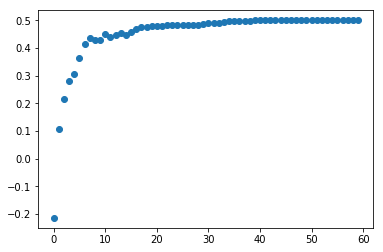

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(60)], "o")

##2.5.- OOB Out of bang Score

Vamos a plicar la técnica OOB para mejorarlos indicadores del modelo

In [0]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Error Muestras Entrenamiento: 8.857366372414257
Error Muestras Test: 22.03985499801061
R2 Muestras Entrenamiento: 0.9371174582608515
R2 Muestras Test: 0.4385854025583146
[8.857366372414257, 22.03985499801061, 0.9371174582608515, 0.4385854025583146, 0.5177273110927444]


Sigue habiendo sobreestimación. Llegados aquí, vamos a aplicar submuestreo para ver si se puede mejorar los parámetros del modelo.




In [0]:
set_rf_samples(2000)

In [0]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 1.2 s, sys: 6.27 ms, total: 1.2 s
Wall time: 660 ms
Error Muestras Entrenamiento: 14.35786277207428
Error Muestras Test: 20.295569867584405
R2 Muestras Entrenamiento: 0.8347656006598386
R2 Muestras Test: 0.5239322799097066
[14.35786277207428, 20.295569867584405, 0.8347656006598386, 0.5239322799097066, 0.665993065517251]


Vemos como a bajado la sobreestimación, pero ha aumentado el error del modelo de entrenamiento.

##2.6.- Estimacion de los parámetros del modelos

##2.6.1.- Profundidad máxima

In [0]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

Tomaremos de nuevo todo el set de muestras

In [0]:
reset_rf_samples()

In [0]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=10, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

Error Muestras Entrenamiento: 13.708888437472297
Error Muestras Test: 20.380667364759347
R2 Muestras Entrenamiento: 0.84936518651892
R2 Muestras Test: 0.5199316922273614
[13.708888437472297, 20.380667364759347, 0.84936518651892, 0.5199316922273614, 0.6721864403309925]


In [0]:
t=model.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

11

##2.6.1.- min_samples_leaf

Para reducir la sobreestimación, vamos a aumentar el número mínimo de eventos en cada final de rama.

In [0]:
model = RandomForestRegressor(n_estimators=12, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=None)
model.fit(X_train, y_train)
print_score(model)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Error Muestras Entrenamiento: 18.49354767353633
Error Muestras Test: 20.380991615592546
R2 Muestras Entrenamiento: 0.7258669916547719
R2 Muestras Test: 0.5199164165953837
[18.49354767353633, 20.380991615592546, 0.7258669916547719, 0.5199164165953837, 0.6236614265826954]


In [0]:
t=model.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

12

#3.- Estudio de variables principales.



In [0]:
fi = rf_feat_importance(model, X_train);fi[:25]

,cols,imp
13,insulin-1,0.632563
19,deltasgv,0.122818
1,sgv,0.082215
12,insulin-2,0.033734
23,ia,0.017220
9,insulin-5,0.011342
0,bolusiob,0.010007
2,Tendencia (#1),0.009482
5,Week,0.009024
6,Day of week (number),0.008092


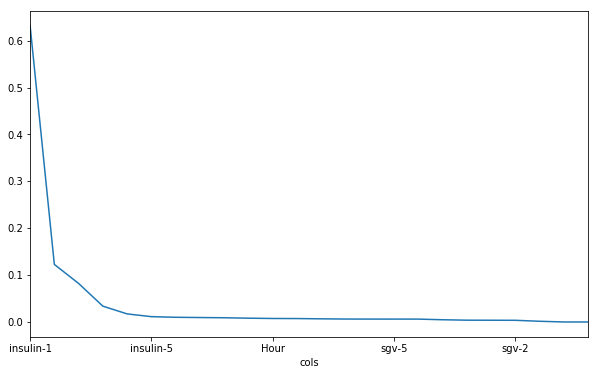

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

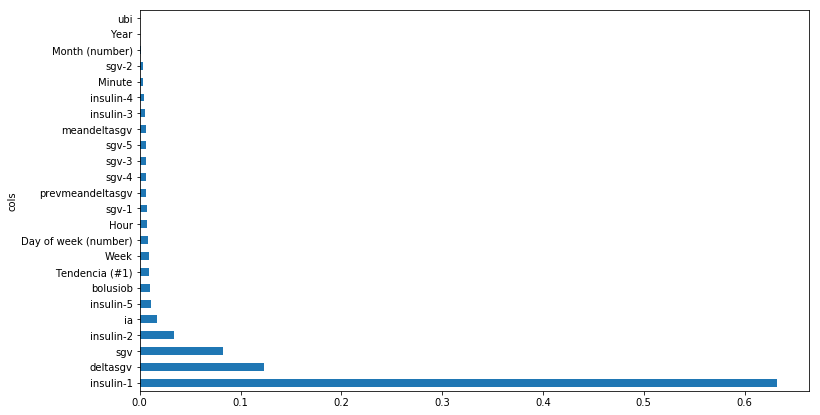

In [0]:
plot_fi(fi[:26]);

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

17

In [0]:
df_keep = X[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
df_keep.shape

(6746, 17)

In [0]:
model = RandomForestRegressor(n_estimators=12, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Error Muestras Entrenamiento: 18.78534213612086
Error Muestras Test: 20.096645123843164
R2 Muestras Entrenamiento: 0.7171481079292492
R2 Muestras Test: 0.5332187937705442
[18.78534213612086, 20.096645123843164, 0.7171481079292492, 0.5332187937705442, 0.6175382662860491]


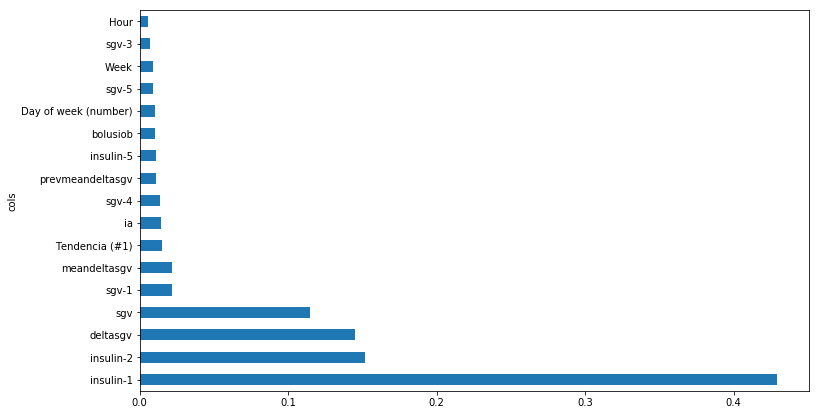

In [0]:
fi = rf_feat_importance(model, df_keep)
plot_fi(fi);

##4.- Eliminando variables redundantes

Se va a identificar variables. El grafico (endograma) se agrupan variables que tienen las mismas características. Aquellas variables que quedan solas, no tienen relacion de comportamiento con otras. Las que se muestran compartidas se pueden eliminar y dejar sólo una .

In [0]:
from scipy.cluster import hierarchy as hc

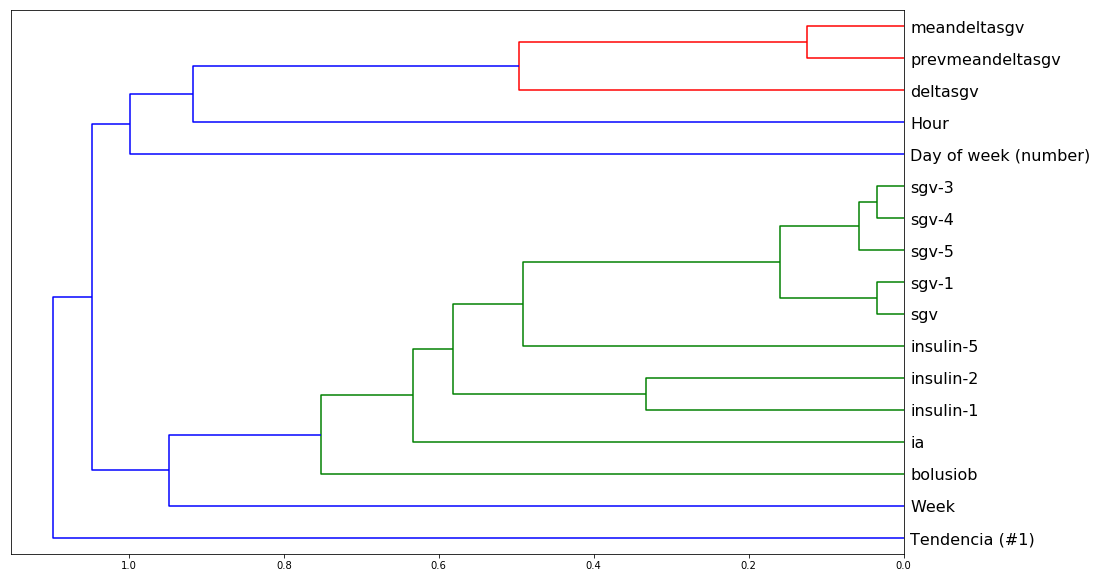

In [0]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

El modelo no presenta variables redundantes.

##5.- TREE INTERPRETER

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df, n_trn)

In [0]:
row = X_valid.values[None,0]; row

array([[100.     ,  -2.     , 200.     ,  75.     ,  83.37167,  75.     ,   0.76   ,   6.     ,  25.     ,
          1.     ,  20.     , 202.     ,   2.     , 196.     , 198.     , 194.     ,   1.     ]])

In [0]:
prediction, bias, contributions = ti.predict(model, row)

In [0]:
prediction[0], bias[0]

(array([76.89012]), 68.39726830147855)

In [0]:
idxs = np.argsort(contributions[0])

In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('insulin-2', 6.0, -8.959948881412224),
 ('deltasgv', 0.76, -7.667347720544735),
 ('insulin-5', 6.0, -2.342163664524216),
 ('prevmeandeltasgv', 100.0, -2.112623193502511),
 ('Day of week (number)', 56.0, -0.9722018636629954),
 ('bolusiob', 25.0, -0.9667951943110958),
 ('Tendencia (#1)', 1.0, -0.6405760227650816),
 ('ia', 2019.0, -0.2539720422927303),
 ('Week', 20.0, -0.1929889986907535),
 ('sgv-3', 100.0, 0.0),
 ('Hour', 75.0, 0.0),
 ('sgv-5', 194.0, 0.32835447263017414),
 ('meandeltasgv', 196.0, 0.5299049474736842),
 ('sgv-4', 75.0, 1.3167976080086614),
 ('sgv-1', 100.0, 2.299252580165417),
 ('sgv', 200.0, 4.932576445696474),
 ('insulin-1', 100.0, 23.1945841447947)]

In [0]:
contributions[0].sum()

8.492852617062766

##6.- EXTRAPOLACION

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df_keep.head()

,insulin-1,deltasgv,sgv,insulin-2,ia,insulin-5,bolusiob,Tendencia (#1),Week,Day of week (number),Hour,sgv-1,prevmeandeltasgv,sgv-4,sgv-3,sgv-5,meandeltasgv
0,75.0,0.477391,142,50.0,68.882861,75.0,0.114437,6,20,3,6,145,0.477585,150,149,151,0.477292
1,25.0,-5.000000,137,75.0,68.882861,50.0,0.112676,6,20,3,6,142,0.477585,149,147,150,-5.000000
2,75.0,7.000000,144,25.0,68.882861,75.0,0.110915,6,20,3,6,137,-5.000000,147,145,149,1.000000
3,50.0,-4.000000,140,75.0,68.882861,50.0,0.109155,6,20,3,6,144,1.000000,145,142,147,-0.666667
4,50.0,-1.000000,139,50.0,68.882861,75.0,0.107394,6,20,3,6,140,-0.666667,142,137,145,-0.750000


In [0]:
X_train.shape, X_valid.shape, df.shape

((5546, 17), (1200, 17), (6746, 25))

In [0]:
model = RandomForestRegressor(n_estimators=12, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(x, y)
model.oob_score_

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9790953691835937

In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(x, y)
model.oob_score_

0.9820394762999486

In [0]:
fi = rf_feat_importance(model, x); fi[:13]

,cols,imp
8,Week,0.859668
9,Day of week (number),0.079123
6,bolusiob,0.020235
4,ia,0.009244
15,sgv-5,0.007445
10,Hour,0.006583
13,sgv-4,0.003957
2,sgv,0.003329
11,sgv-1,0.003086
14,sgv-3,0.002498


In [0]:
feats=['Week', 'Day of week (number)', 'bolusiob']

In [0]:
(X_train[feats]/1000).describe()

,Week,Day of week (number),bolusiob
count,5546.000000,5546.000000,5546.000000
mean,0.022221,0.003981,0.000710
std,0.001450,0.002009,0.001102
min,0.020000,0.001000,0.000000
25%,0.021000,0.002000,0.000000
50%,0.022000,0.004000,0.000220
75%,0.023000,0.006000,0.000917
max,0.025000,0.007000,0.008500


In [0]:
(X_valid[feats]/1000).describe()

,Week,Day of week (number),bolusiob
count,1200.000000,1200.000000,1200.000000
mean,0.025212,0.003715,0.000963
std,0.000409,0.001984,0.001118
min,0.025000,0.001000,0.000000
25%,0.025000,0.002000,0.000112
50%,0.025000,0.004000,0.000600
75%,0.025000,0.005000,0.001483
max,0.026000,0.007000,0.008837


In [0]:
x.shape

(6746, 17)

In [0]:
x_drop = x.copy()

In [0]:
x_drop.drop(feats, axis=1, inplace=True)


In [0]:
x_drop.head()

,insulin-1,deltasgv,sgv,insulin-2,ia,insulin-5,Tendencia (#1),Hour,sgv-1,prevmeandeltasgv,sgv-4,sgv-3,sgv-5,meandeltasgv
0,75.0,0.477391,142,50.0,68.882861,75.0,6,6,145,0.477585,150,149,151,0.477292
1,25.0,-5.000000,137,75.0,68.882861,50.0,6,6,142,0.477585,149,147,150,-5.000000
2,75.0,7.000000,144,25.0,68.882861,75.0,6,6,137,-5.000000,147,145,149,1.000000
3,50.0,-4.000000,140,75.0,68.882861,50.0,6,6,144,1.000000,145,142,147,-0.666667
4,50.0,-1.000000,139,50.0,68.882861,75.0,6,6,140,-0.666667,142,137,145,-0.750000


In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(x_drop, y)
model.oob_score_

0.21863389271959466

In [0]:
fi = rf_feat_importance(model, x); fi[:20]

,cols,imp
4,ia,0.232266
2,sgv,0.124730
6,sgv-5,0.122934
8,prevmeandeltasgv,0.107560
5,sgv-1,0.089356
3,insulin-2,0.079416
0,insulin-1,0.074961
1,deltasgv,0.072236
9,insulin-5,0.068212
7,Tendencia (#1),0.028327


In [0]:
df_keep.shape

(6746, 17)

In [0]:
feats=['Hour', 'ia', 'sgv-5','Week', 'Day of week (number)', 'bolusiob']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
model = RandomForestRegressor(n_estimators=25, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(X_train, y_train)
print_score(model)

Error Muestras Entrenamiento: 18.702991925091542
Error Muestras Test: 19.813215230305083
R2 Muestras Entrenamiento: 0.7196225752772654
R2 Muestras Test: 0.5462923005545246
[18.702991925091542, 19.813215230305083, 0.7196225752772654, 0.5462923005545246, 0.6496118690801904]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    model = RandomForestRegressor(n_estimators=25, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
    model.fit(X_train, y_train)
    print(f)
    print_score(model)

Hour
Error Muestras Entrenamiento: 18.705800198552684
Error Muestras Test: 20.29029901213864
R2 Muestras Entrenamiento: 0.7195383710390558
R2 Muestras Test: 0.5241795218757987
[18.705800198552684, 20.29029901213864, 0.7195383710390558, 0.5241795218757987, 0.6540218570459546]
ia
Error Muestras Entrenamiento: 18.786156947439085
Error Muestras Test: 19.937351939588776
R2 Muestras Entrenamiento: 0.7171235700826996
R2 Muestras Test: 0.540589216230545
[18.786156947439085, 19.937351939588776, 0.7171235700826996, 0.540589216230545, 0.6509560163976693]
sgv-5
Error Muestras Entrenamiento: 18.66209999373827
Error Muestras Test: 20.117418577433607
R2 Muestras Entrenamiento: 0.7208472606977495
R2 Muestras Test: 0.5322532923871972
[18.66209999373827, 20.117418577433607, 0.7208472606977495, 0.5322532923871972, 0.6553531790837672]
Week
Error Muestras Entrenamiento: 18.796830934760212
Error Muestras Test: 19.98593902233833
R2 Muestras Entrenamiento: 0.7168020272331199
R2 Muestras Test: 0.53834733091293

In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['bolusiob','Day of week (number)','Week','sgv-5','ia','Hour'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
model = RandomForestRegressor(n_estimators=25, min_samples_leaf=20, n_jobs=-1, max_depth=11, oob_score=True, max_features=0.5)
model.fit(X_train, y_train)
print_score(model)

Error Muestras Entrenamiento: 19.338009360982642
Error Muestras Test: 20.2916854843928
R2 Muestras Entrenamiento: 0.7002602077555196
R2 Muestras Test: 0.5241144923333432
[19.338009360982642, 20.2916854843928, 0.7002602077555196, 0.5241144923333432, 0.6479966031356655]


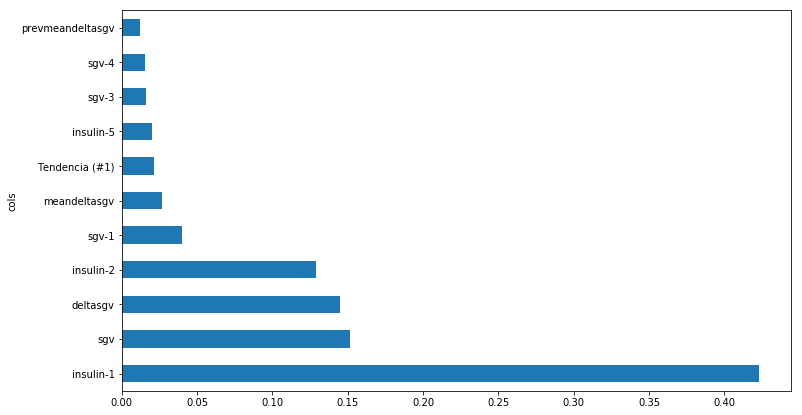

In [0]:
plot_fi(rf_feat_importance(model, X_train));

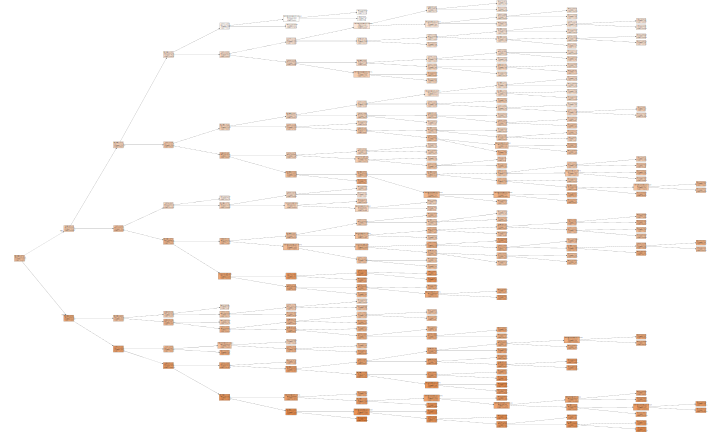

In [0]:
draw_tree(model.estimators_[0], X_train, precision=3)

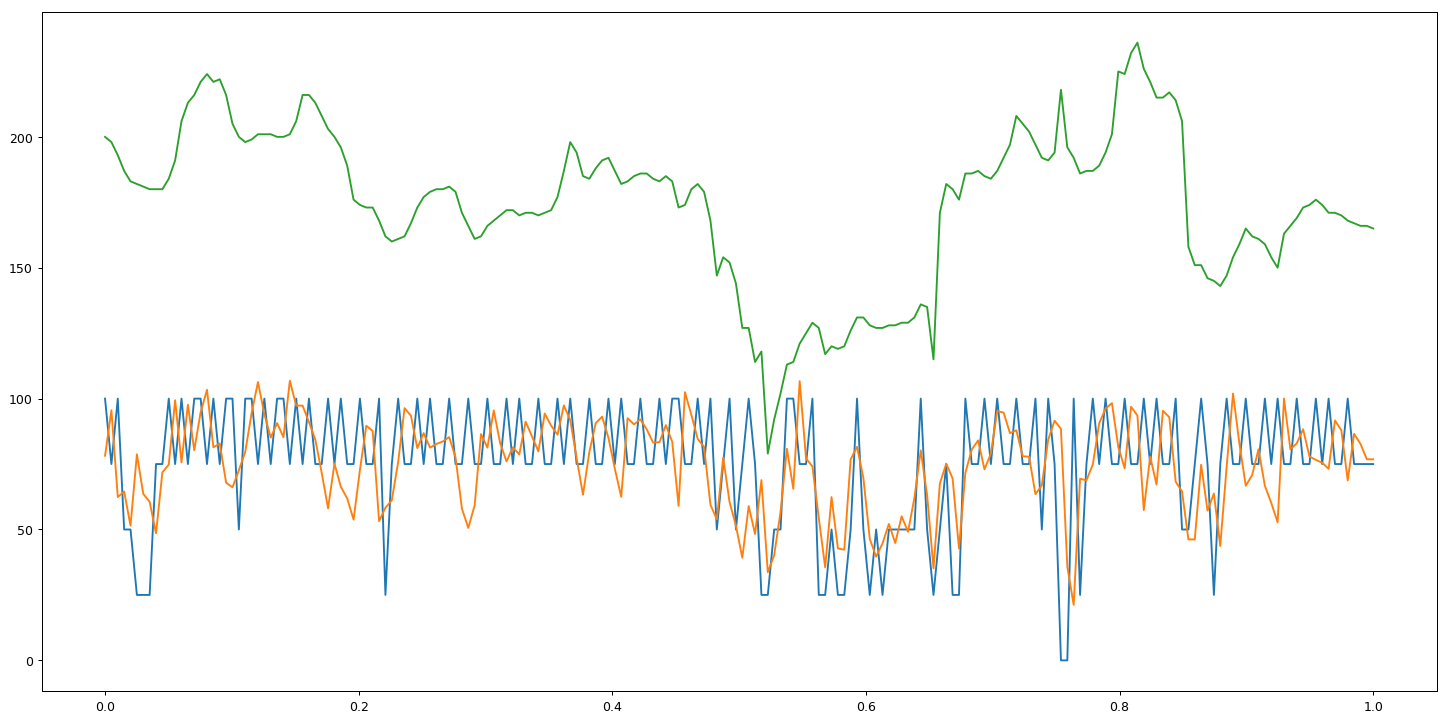

In [0]:
plt.figure(1, figsize=(20,10), dpi=90)

plt.plot(np.linspace(0,1,200),y_valid[:200], label='Insulina Real')
plt.plot(np.linspace(0,1,200),model.predict(X_valid)[:200], label='Insulina Predicción')
plt.plot(np.linspace(0,1,200),X_valid['sgv'].T.to_numpy()[:200], label='Nivel Glucosa')
#plt.legend(loc=2)
#plt.title='erwgfergergthtrhrte'


In [0]:
prediccion = pd.DataFrame(model.predict(X_valid))

In [0]:
def cuantificador(val):
  cociente = val//25
  resto = val % 25
  if resto > 12.5:
    resultado = 25*(cociente+1)
  else:
    resultado = 25*cociente
  return (resultado)

In [0]:
prediccion['cuantif']=prediccion[0].apply(lambda x: cuantificador(x))

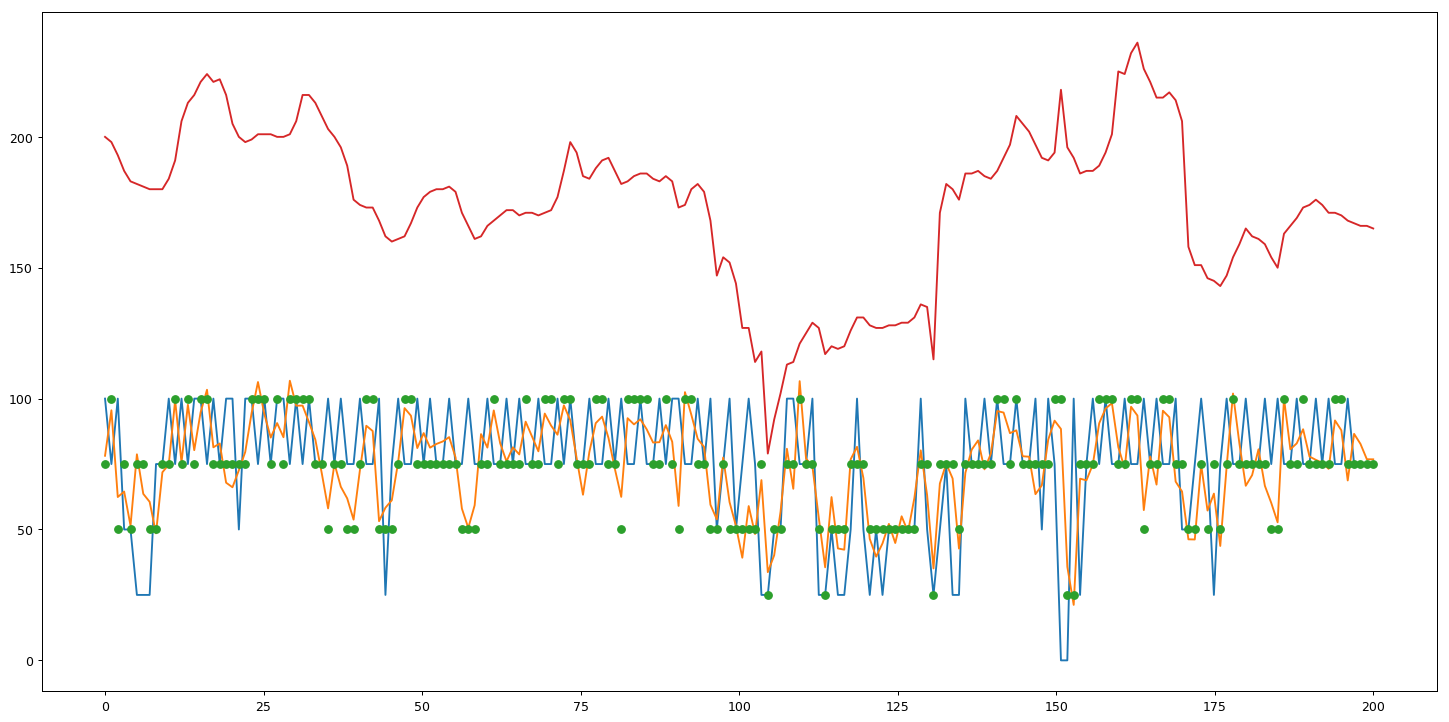

In [0]:
plt.figure(1, figsize=(20,10), dpi=90)

plt.plot(np.linspace(0,200,200),y_valid[:200], label='Insulina Real')
plt.plot(np.linspace(0,200,200),model.predict(X_valid)[:200], label='Insulina Predicción')
plt.plot(np.linspace(0,200,200),prediccion.cuantif[:200], 'o', label='Insulina Prediccion Cuantificada')
plt.plot(np.linspace(0,200,200),X_valid['sgv'].T.to_numpy()[:200], label='Nivel Glucosa')
#plt.legend(loc=2)
#plt.title='erwgfergergthtrhrte'

In [0]:
prediccion['cuantif'][:200].sum()/1000

14.9

In [0]:
model.predict(X_valid)[:200].sum()/1000

14.940064072399494

In [0]:
y_valid[:200].sum()/1000

15.2